### Import Library

In [1]:
import os
import pandas as pd
import torch
from argparse import Namespace
from torch.utils.data import DataLoader
from MLPpatchLatent import Model

import sys
sys.path.insert(1, "/Users/yeojisu/Documents/House-Price-Index-Prediction")

from config.US_6 import *
from model.dfm_model import * 
from model.var_model import *
from model.kalman_filter import *
from utils.deep_learning import *
from utils.data_loader import *
from utils.visualization import *

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information")
warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Load Data

In [2]:
target_df = load_target_data_us(TARGET_PATH)
target_df_train = target_df[target_df.index < TEST_DATE]
target_df_test  = target_df[target_df.index >= TEST_DATE]

### Dynamic Factor Model (DFM)

In [3]:
dfm_results = run_dfm(target_df_train, target_df_test, REFERENCE_DATE, 5)
# train phase 
optimal_factors = dfm_results["optimal_factors"]
shared_component_final_train = dfm_results["shared_component_final_train"]
loadings     = dfm_results["loadings"]
scale_factor = dfm_results["scale_factor"]
offset       = dfm_results["offset"]

combined_array = dfm_results["combined_shared_component"]

factor_column_list = []
for i in range(optimal_factors):
    factor_column_list.append("factor"+str(i+1))

factor_df = pd.DataFrame(combined_array, columns=factor_column_list, index=target_df.index)


Optimization terminated successfully.
         Current function value: 23.054809
         Iterations: 37
         Function evaluations: 25634


In [4]:
df = load_feature_data_us(FEATURE_PATH, FEATURE_COLUMN, TRAIN_DATE)
df = pd.concat([df, factor_df], axis=1)
df = df.dropna()


### Vector Autoregression (VAR)

{'call_rate': 21, 'bond_10yr': 22, 'M1_velocity': 22, 'M2_real': 23, 'CPI': 17, 'inflation': 23, 'employee': 1, 'total_construction': 22, 'IPI_supply': 5, 'house_supply': 2, 'factor2': 1}


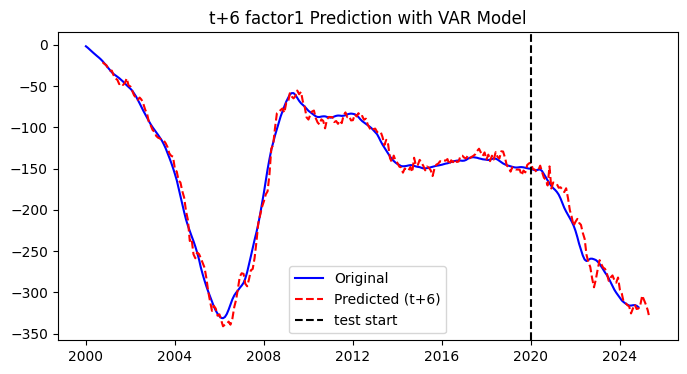

{'call_rate': 19, 'bond_10yr': 22, 'NASDAQ': 7, 'M1_velocity': 23, 'M2_real': 6, 'M2_velocity': 5, 'financial': 21, 'nonfinancial': 22, 'CPI': 23, 'inflation': 22, 'GDP': 23, 'total_construction': 1, 'IPI_supply': 1, 'house_supply': 19, 'factor1': 23}


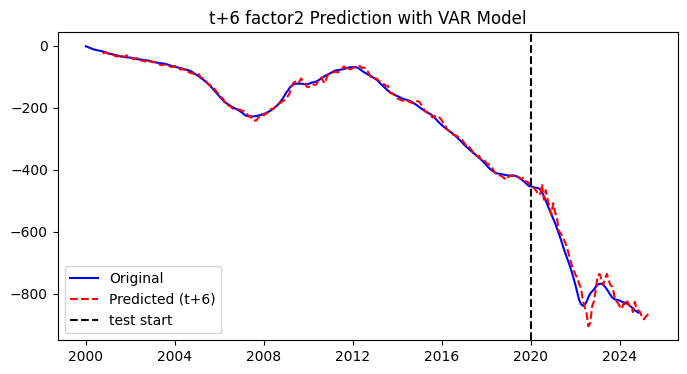

In [5]:
forecast_dfs = {} 
for i in range(optimal_factors):
    factor_name = f"factor{i+1}"
    
    forecast_dfs[factor_name] = var_forecast(df, factor_name, TEST_DATE, MAXLAG_FACTOR, SELECTED_LAG_FACTOR, FORECAST_HORIZON)
    
    plot_var_forecast(df, forecast_dfs[factor_name], factor_name, TEST_DATE, FORECAST_HORIZON)

### Kalman Filter

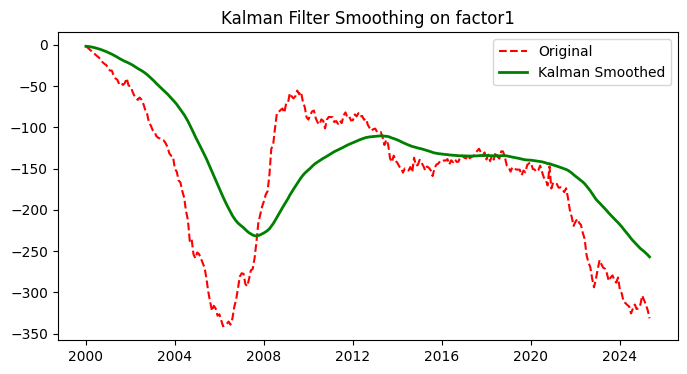

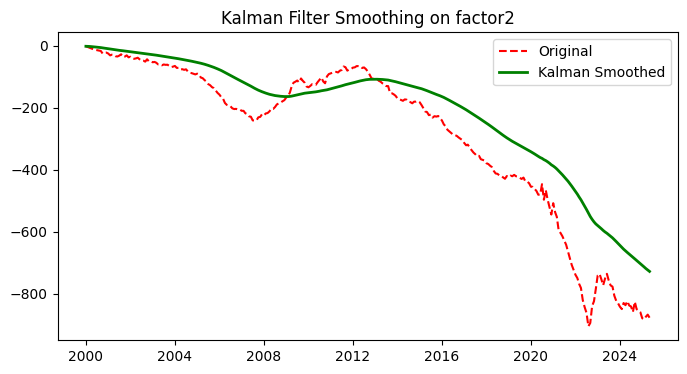

In [6]:
smoothed_factors = {} 
for i in range(optimal_factors):
    factor_name = f"factor{i+1}"
    combined_series = pd.concat([df[factor_name][TRAIN_DATE:TRAIN_DATE[:6]+str(FORECAST_HORIZON+SELECTED_LAG_FACTOR)+'-15'], forecast_dfs[factor_name][factor_name]])
    smoothed = apply_kalman_filter(combined_series, KALMAN_OBSERVATION_COV, KALMAN_TRANSITION_COV)
    plot_kalman_filter_result(combined_series, smoothed, factor_name)
    smoothed_factors[factor_name] = smoothed


### Deep Residual Learning

In [7]:
smoothed_factors_df = pd.concat(list(smoothed_factors.values()), axis=1)
smoothed_factors_df.columns = [f"factor{i+1}" for i in range(optimal_factors)]

common_index = target_df.index.intersection(smoothed_factors_df.index)
smoothed_factors_df = smoothed_factors_df.loc[common_index]
target_df_common = target_df.loc[common_index]

target_mean = target_df_train.mean().values
factors_adjusted = (smoothed_factors_df.values @ loadings.T) * scale_factor + target_mean + offset

resid = target_df_common - factors_adjusted
resid = resid.reset_index().rename(columns={"index": "Date"})
resid["Date"] = pd.to_datetime(resid["Date"])

⭐️ Calculate Distance Matrix

In [17]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, wasserstein_distance
from scipy import stats

# 샘플 데이터 (실제 데이터로 대체하세요)
# original_train, original_test, ice_train, ice_test = ...

def cohen_d(x, y):
    # x와 y는 두 데이터셋
    diff_mean = np.mean(x) - np.mean(y)
    pooled_std = np.sqrt(((len(x) - 1) * np.std(x, ddof=1) ** 2 + (len(y) - 1) * np.std(y, ddof=1) ** 2) / (len(x) + len(y) - 2))
    return diff_mean / pooled_std

# 히스토그램 기반 확률분포로 변환
def to_prob_dist(arr, bins=100):
    hist, bin_edges = np.histogram(arr, bins=bins, range=(np.min(arr), np.max(arr)), density=True)
    # 0 값 방지 → 작은 값 추가 (for KL)
    hist += 1e-10
    return hist / hist.sum()

# 분포 거리 계산 함수
def compute_metrics(p, q):
    jsd = jensenshannon(p, q)
    kl = entropy(p, q)  # KL(p||q)
    wass = wasserstein_distance(p, q)
    return jsd, wass, kl

# 각 데이터에 대해 분포 변환
for col in target_df.columns: 
    
    orig_train_dist = to_prob_dist(target_df_train[col])
    orig_test_dist  = to_prob_dist(target_df_test[col])
    ice_train_dist  = to_prob_dist(resid[:180][col])
    ice_test_dist   = to_prob_dist(resid[180:][col])
    

    # 계산
    jsd_orig, wass_orig, kl_orig = compute_metrics(orig_train_dist, orig_test_dist)
    jsd_ice,  wass_ice,  kl_ice  = compute_metrics(ice_train_dist,  ice_test_dist)
    
    statistic_AB, p_value_AB = stats.ks_2samp(target_df_train[col], target_df_test[col])
    statistic_CD, p_value_CD = stats.ks_2samp(resid[:180][col], resid[180:][col])

    cohen_d_AB = cohen_d(target_df_train[col], target_df_test[col])
    cohen_d_CD = cohen_d(resid[:180][col], resid[180:][col])

    # Difference
    diff_co = cohen_d_AB - cohen_d_CD
    diff_ks = p_value_AB - p_value_CD
    diff_jsd  = jsd_orig - jsd_ice
    diff_wass = wass_orig - wass_ice
    diff_kl   = kl_orig - kl_ice

    
    # Relative Reduction (%)
    rel_co   = 100 * diff_co / cohen_d_AB
    rel_ks   = -(100 * diff_ks / p_value_AB)
    rel_jsd  = 100 * diff_jsd  / jsd_orig
    rel_wass = 100 * diff_wass / wass_orig
    rel_kl   = 100 * diff_kl   / kl_orig
    # print(col)
    print(round(rel_ks,3))
    
    # DataFrame: 방식 1 + 방식 2 통합
    df_compare = pd.DataFrame({
        'Metric': ['Jensen-Shannon Divergence', 'Wasserstein Distance', 'KL Divergence', 'KS', 'Cohen'],
        # 'Original': [jsd_orig, wass_orig, kl_orig, p_value_AB],
        # 'ICE': [jsd_ice, wass_ice, kl_ice, p_value_CD],
        # 'Decrease': [diff_jsd, diff_wass, diff_kl, diff_ks],
        'Relative Reduction (%)': [
            round(rel_jsd,3), 
            round(rel_wass,3), 
            round(rel_kl,3), 
            round(rel_ks,3),
            round(rel_co, 3)]
    })
    # print(df_compare)

5.453850088386375e+40
1.6268510042799773e+43
3.2066660515582694e+17
4.4627117995749766e+28
7912768131232308.0
-100.0
9584686203687.615
5.366468118600339e+34
36428883.2
2.1703734904549622e+36
-100.0
5.435562199288258e+30
3.893549383907967e+26
8.554598196756894e+30
463206739284.92
460452952306.99
-97.332
5.065856811281319e+50
1.935486322418591e+42
2.6642085465760554e+45


/Users/yeojisu/opt/anaconda3/envs/cv2024/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  5%|▌         | 50/1000 [10:57<3:28:08, 13.15s/it]

Early stopping triggered.


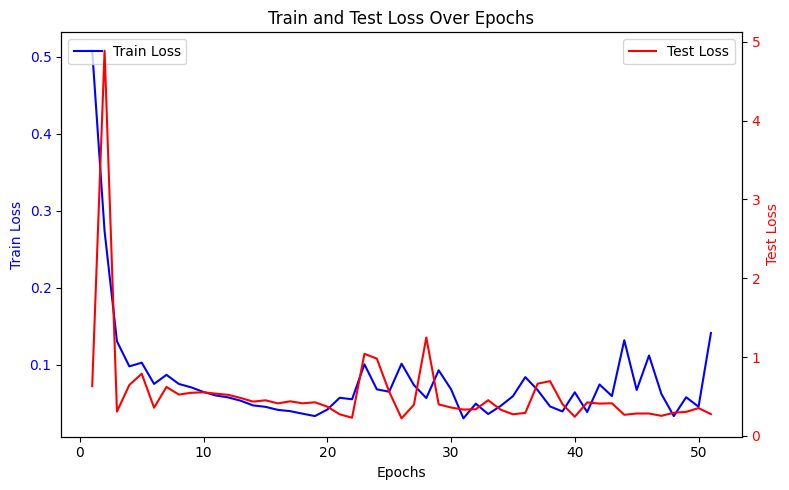

In [8]:
window_size  = WINDOW_SIZE
forecast_size = FORECAST_HORIZON
idx = resid[resid['Date'] == pd.to_datetime(TEST_DATE)].index[0]
train_df = resid.iloc[:idx]
test_df  = resid.iloc[idx - (forecast_size + window_size):].reset_index(drop=True)

columns_to_use = resid.columns.drop("Date")
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, "Date", columns_to_use)
train_x, train_y, train_date_list = time_slide_df(train_df_fe, window_size, forecast_size, "Date", columns_to_use)
test_x, test_y, test_date_list   = time_slide_df(test_df_fe, window_size, forecast_size, "Date", columns_to_use)

configs = Namespace(
    seq_len      = window_size,
    pred_len     = forecast_size,
    ker_len      = 25,
    enc_in       = len(columns_to_use),
    patch_len    = 3,
    stride       = 2,
    padding_patch= 'end',
    revin        = True,
    ma_type      = 'ema',
    alpha        = 0.3,
    beta         = 0.3,
    patch_size   = 3,
    patch_stride = 2,
    obs_cov = 1,
    trans_cov = 1,
)
train_ds = Data(train_x, train_y)
test_ds  = Data(test_x, test_y)
batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_dl  = DataLoader(test_ds, batch_size=len(test_df), shuffle=False)

model = Model(configs=configs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
patience   = 20
save_path  = os.path.join(DIR_PATH, f"model{VERSION}.pth")

train_loss_list, test_loss_list = train_deep_learning_model(model, train_dl, test_dl, criterion, optimizer, num_epochs, patience, save_path)
plot_loss_curve(train_loss_list, test_loss_list)



Draw the Results

SanFrancisco_HPI: RMSE=20.243, MAE=15.73799991607666
LosAngeles_HPI: RMSE=16.025, MAE=12.694999694824219
Seattle_HPI: RMSE=22.852, MAE=19.05900001525879
SanDiego_HPI: RMSE=22.622, MAE=18.172000885009766
Chicago_HPI: RMSE=11.866, MAE=10.642999649047852
Dallas_HPI: RMSE=25.486, MAE=21.236000061035156
NewYork_HPI: RMSE=12.559, MAE=10.954999923706055
Phoenix_HPI: RMSE=27.244, MAE=20.94700050354004
Boston_HPI: RMSE=16.645, MAE=14.567999839782715
Miami_HPI: RMSE=22.021, MAE=15.961999893188477
Denver_HPI: RMSE=16.52, MAE=12.26200008392334
Atlanta_HPI: RMSE=16.154, MAE=14.067999839782715
LasVegas_HPI: RMSE=17.836, MAE=12.944999694824219
Tampa_HPI: RMSE=19.544, MAE=13.508000373840332
Portland_HPI: RMSE=12.314, MAE=9.57699966430664
Washington_HPI: RMSE=8.763, MAE=7.24399995803833
Charlotte_HPI: RMSE=20.971, MAE=18.761999130249023
Detroit_HPI: RMSE=7.25, MAE=6.375
Minneapolis_HPI: RMSE=6.239, MAE=4.9730000495910645
Cleveland_HPI: RMSE=12.09, MAE=11.256999969482422


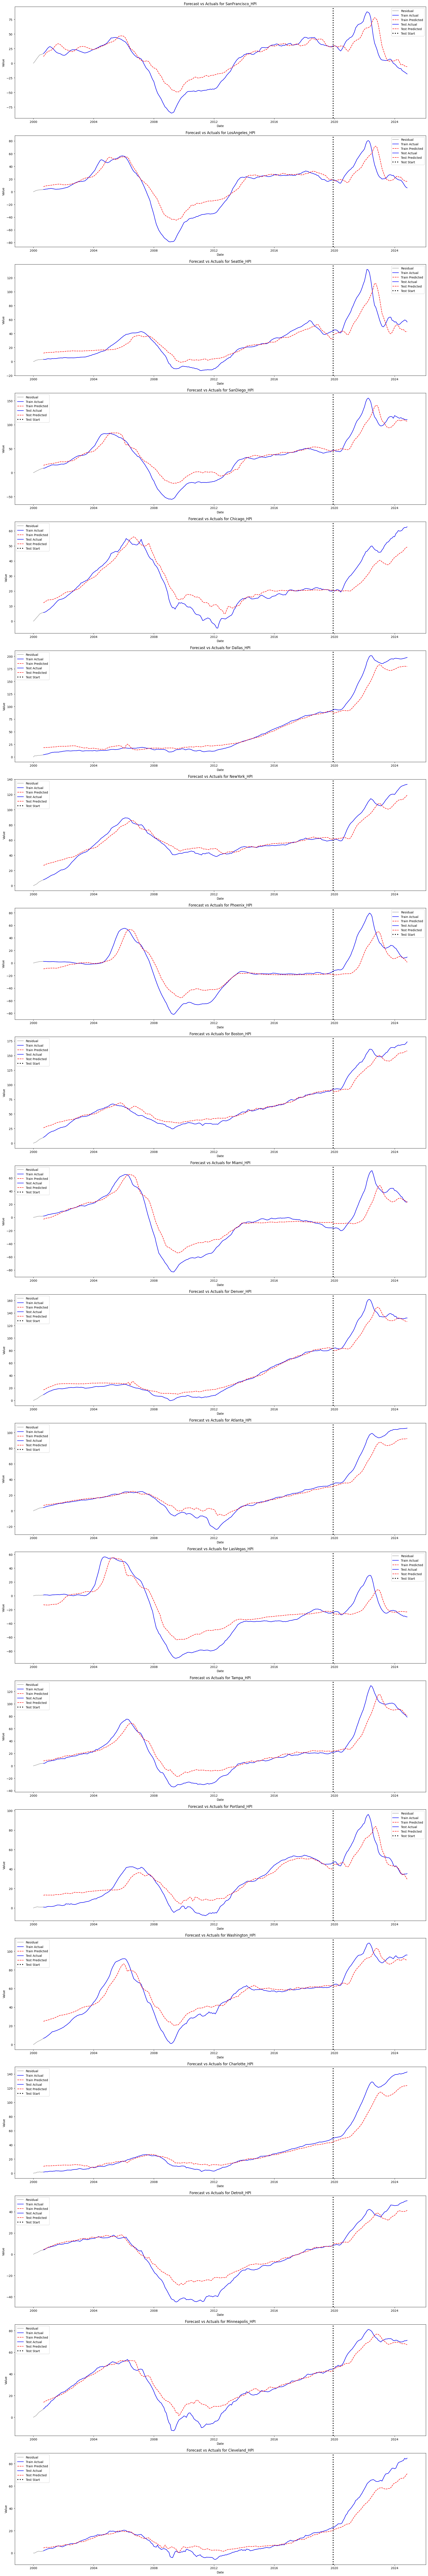

In [9]:
model.load_state_dict(torch.load(save_path))
model.eval()

train_outputs, train_targets = evaluate_model(model, DataLoader(train_ds, batch_size=len(train_ds), shuffle=False))
test_outputs, test_targets   = evaluate_model(model, DataLoader(test_ds, batch_size=len(test_ds), shuffle=False))

train_predicted = train_outputs[:, -1, :].cpu().numpy()
train_actual    = train_targets[:, -1, :].cpu().numpy()
train_dates = train_date_list[:, -1] 

test_predicted  = test_outputs[:, -1, :].cpu().numpy()
test_actual     = test_targets[:, -1, :].cpu().numpy()
test_dates = test_date_list[:, -1] 

plot_deep_learning_results(resid, columns_to_use, train_dates, test_dates,
                           train_actual, train_predicted, test_actual, test_predicted,
                           mean_, std_,
                           DIR_PATH, VERSION)


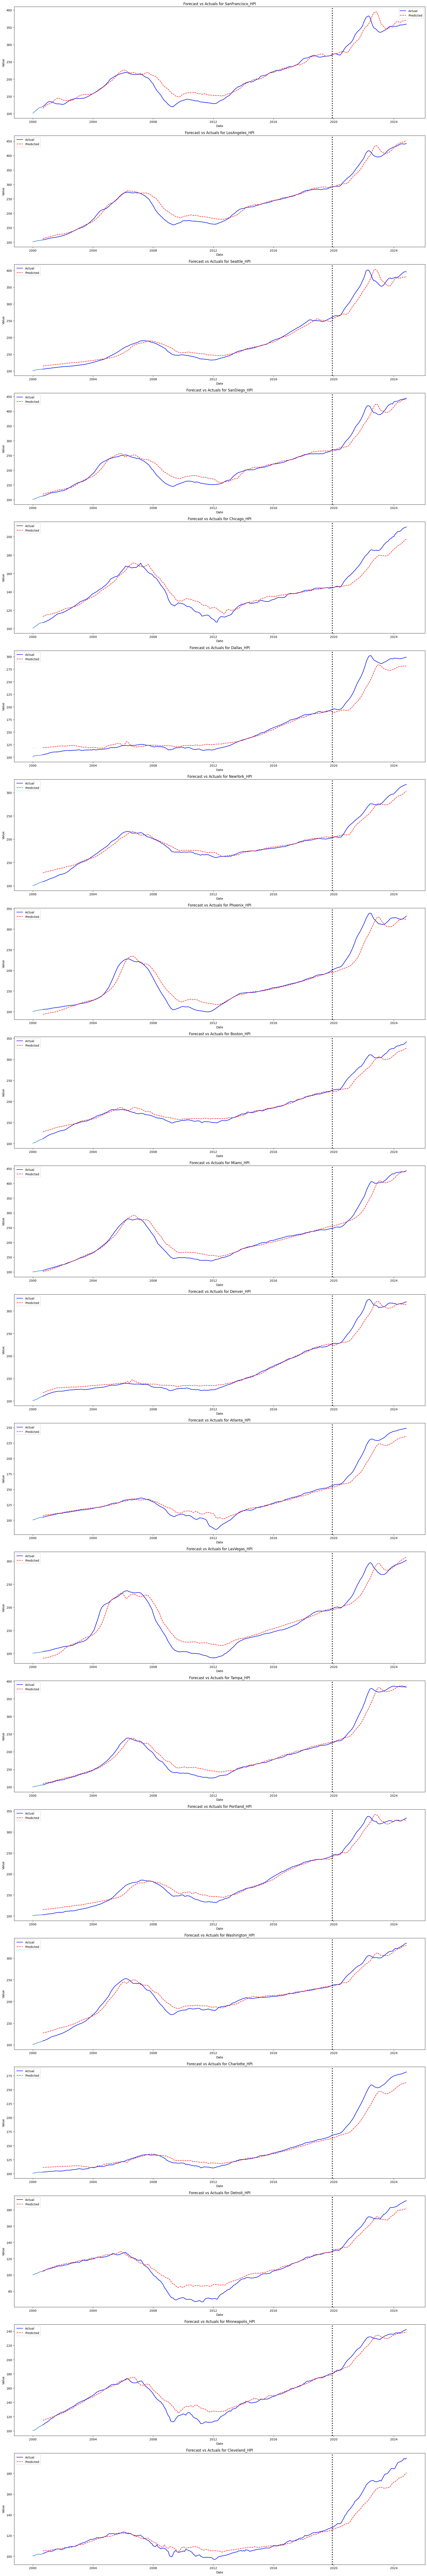

In [10]:
additional_test_x, additional_test_y, additional_test_date = test_time_slide_df(test_df_fe, window_size, forecast_size, "Date", columns_to_use)
addi_test_ds = Data(additional_test_x, additional_test_y)
addi_test_dl  = DataLoader(addi_test_ds, batch_size=len(additional_test_x), shuffle=False)
with torch.no_grad():
    for data, target in addi_test_dl:
        addi_test_output = model(data)
        addi_test_predicted = addi_test_output[:, -1, :].cpu().numpy() 

f = (pd.concat(smoothed_factors,axis=1).values @ loadings.T) * scale_factor + target_df_train.mean().values + offset
f_pd_all = pd.DataFrame(f, index=pd.to_datetime(smoothed_factors['factor1'].index), columns=target_df.columns)

plot_additional_test_predictions(target_df, columns_to_use,
                                 train_actual, train_predicted,
                                 test_actual, test_predicted,
                                 addi_test_predicted,
                                 train_dates, test_dates,
                                 mean_, std_, f_pd_all, forecast_size)